# Calibration of Images
After we get a bunch of images, we first need to preprocess them. This step mainly includes
* Overscan calibration (apply to all images)

Overscan region records the changes of ground voltage during readout. Since what is really measured is the voltage difference between ground and each pixel, one need to make sure that ground is the same during one readout. This region usually appears to be purely black since the change is usually small even when compared to sky brightness. However, many detectors do not have overscan region, so this step is often skipped.
* Bias calibration (apply to dark, flat and light)

Detectors are usually precharged to a certain votage (offset) to avoid clipping when the signal is low. This offset needs to be removed. By reading out once immediately after another, one could get an image with this offset plus the readout noise.
* Dark calibration (apply to flat and light)

Even when there is no photoelectron, due to non-zero temperature (in Kelvin), electrons are still being excited onto higher energy levels and creating "signals". This term is called dark current because it scales linearly with exposure time. It needs to be subtracted from the image. By taking an image with shutter closed, one could get an image composed of dark current, readout noise and the offset.
* Flat calibration (apply to light)

Some pixels are more sensitive to light but others are less. The optics can also have vignetting and dust particles blocking light. By taking an image of an uniformly illuminated object, one could measure the response of the optical system + detector and correct it out.

Normally, we take multiple dark, flat and bias fields. Before we start we need to combine them into one master frame. The process is the same as stacking aligned images. In short
$$\rm Master\ Bias=<Bias_i>$$
$$\rm Master\ Dark=<Dark_i-Master\ Bias>$$
$$\rm Master\ Flat=<Flat_i-Master\ Bias-a\times Master\ Dark>$$

After that, we can calibrate the light images

$$\rm Calibrated\ Light=\frac{Light-Master\ Bias-b\times Master\ Dark}{Master\ Flat}$$

In [1]:
# Import necessary modules and functions
from astropy.coordinates import SkyCoord
import astropy.constants as c
from astropy.io import fits
from astropy import log
from astropy.nddata import CCDData
from astropy.stats import sigma_clipped_stats
import astropy.units as u
import ccdproc
from ccdproc import ccd_process, combine
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline


log.setLevel('WARN')

### Creating master bias, dark and flat images
Master calibration images are created by stacking (averaging) over many individual calibration images. Individual calibration images can have small differences in its mean value, especially for individual sky flats. Therefore, we need to linearly scale the images before averaging.

In [2]:
def sigma_clipped_mean(img_data, xlim, ylim):
    '''
    Scaling images according to its 10 times 3-sigma clipped mean.
    
    Parameters
    ----------
    img_data: array-like, the input image data
    xlim: 2-list, the maximum and minimum of x corrdinate of the region
    ylim: 2-list, the maximum and minimum of y corrdinate of the region
    
    Returns
    -------
    m: float, the scaling factor of the image
    '''
    m = 1.0 / sigma_clipped_stats(img_data[xlim[0]: xlim[1], ylim[0]: ylim[1]], maxiters=10)[0]
    return m


def median_scaling(img_data, xlim, ylim):
    '''
    Scaling images according to its median within a region
    
    Parameters
    ----------
    img_data: array-like, the input image data
    xlim: 2-list, the maximum and minimum of x corrdinate of the region
    ylim: 2-list, the maximum and minimum of y corrdinate of the region
    
    Returns
    -------
    scaling: float, the scaling factor of the image
    '''
    scaling = 1.0 / np.nanmedian(img_data[xlim[0]: xlim[1], ylim[0]: ylim[1]])
    return scaling


def stack(areg, oname, unit='adu', method = 'median', scaling=None, extremeclip=[1, 1], sigmaclip=[4.0, 3.0]):
    '''
    Stack images with extreme value clipping and sigma clipping
    
    Parameters
    ----------
    areg: str, filename pattern of images
    outdir: str, output directory for processed data, this directory must exist beforehand
    unit: optional, str or astropy.units, default astropy.units.adu, the unit that the pixel data of the light images are in
    method: optional, str, default median, method to combine images based on what images you are using, options are average, median, sum
    scaling: optional, function, default sigma_clipped_mean, the scaling function for each frame
    extremeclip: optional, list with length=2, default [1, 1], the lowest extremeclip[0] and highest extremeclip[1] values will be clipped
    sigmaclip: optional, list with length=2, default [4.0, 3.0], the low threshold and high threshold in sigma
    
    Returns
    -------
    None
    '''
    alist = glob.glob(areg)
    # Stacking
    # Caveat: everything is saved in memory, so be careful when processing more than 4GB of images
    # Caveat: header is broken in many ways. EXPTIME, GAIN, RDNOISE, MJD_OBS are not updated
    outdata = combine(alist, method= method, scale=scaling, unit=unit,
                      clip_extrema=True, nlow=extremeclip[0], nhigh=extremeclip[1],
                      sigma_clip=True, sigma_clip_low_thresh=sigmaclip[0], sigma_clip_high_thresh=sigmaclip[1])
    outdata.write(oname, overwrite=True)
    print("Stack Finished")
    

def calibrate(lreg, mbias, mdark, mflat, outdir, unit='adu', exptime='EXPTIME', darkscale=True):
    '''
    Bias, dark and flat calibrate images
    
    Parameters
    ----------
    lreg: str, filename pattern of images
    mbias: astropy.nddata.CCDData, CCDData containing master bias
    mdark: astropy.nddata.CCDData, CCDData containing master dark
    mflat: astropy.nddata.CCDData, CCDData containing master flat
    outdir: str, output directory for processed data, this directory must exist beforehand
    unit: optional, str or astropy.units, default 'adu', the unit that the pixel data of the light images are in
    exptime: optional, str, default 'EXPTIME', the key for exposure time of the light images
    darkscale: optional, boolean, default True, whether to scale master dark according to exposure time
    
    Returns
    -------
    None
    '''
    for each_l in glob.glob(lreg):
        lccd = CCDData.read(each_l, unit=unit)
        # Yeah, this package is inspired by iraf
        rccd = ccd_process(lccd, master_bias=mbias, dark_frame=mdark, master_flat=mflat, 
                           exposure_key=exptime, dark_scale=darkscale, exposure_unit=u.s,
                           gain_corrected=False)
        rccd.write(os.path.join(outdir, os.path.basename(each_l)), overwrite=True)
     
    print("Calibration Finished")

def imexamine(ireg, xlim, ylim, unit='adu'):
    '''
    Examine an image and print out the mean, median, std, min and max within a region.
    
    Parameters
    ----------
    ireg: str, filename pattern of images
    xlim: 2-list, the maximum and minimum of x corrdinate of the region
    ylim: 2-list, the maximum and minimum of y corrdinate of the region
    
    Returns
    -------
    None
    '''
    print('File  Mean  Median  Std  Min  Max')
    for each in glob.glob(ireg):
        iccd = CCDData.read(each, unit=unit)
        img_mean, img_med, img_std = sigma_clipped_stats(iccd.data[xlim[0]: xlim[-1], ylim[0]: ylim[-1]])
        img_min, img_max = np.nanmin(iccd.data), np.nanmax(iccd.data[xlim[0]: xlim[-1], ylim[0]: ylim[-1]])
        print(str(each) + ' %.4f %.4f %.4f %.4f %.4f' % (img_mean, img_med, img_std, img_min, img_max))

Creating master bias is an easy process. We just stack them. However, we would like to check that there are no outliers in the images.

In [3]:
# Master bias
imexamine('*Bias*',[1024, 3072], [1024, 3072])
stack('*Bias*', "mbias.fits", scaling=None)

File  Mean  Median  Std  Min  Max


bias-00010_001s.fit 988.5420 988.0000 8.8506 938.0000 1195.0000


bias-00020_001s.fit 988.6986 989.0000 8.8585 935.0000 1554.0000


bias-00030_001s.fit 988.8390 989.0000 8.8344 935.0000 2496.0000


bias-00040_001s.fit 989.0537 989.0000 8.8460 932.0000 2108.0000


bias-00050_001s.fit 989.0298 989.0000 8.8226 928.0000 1244.0000


bias-00060_001s.fit 989.2290 989.0000 8.8517 941.0000 1225.0000


bias-00070_001s.fit 989.3202 989.0000 8.8343 936.0000 1519.0000


bias-00080_001s.fit 989.4089 989.0000 8.8375 921.0000 1918.0000


bias-00090_001s.fit 989.4670 989.0000 8.8340 940.0000 1796.0000


bias-00100_001s.fit 989.6506 990.0000 8.8400 933.0000 2794.0000


mbias.fits 989.9195 990.0000 3.8570 968.0000 1231.0000


Stack Finished


Creating master dark is not a hard process. We first calibrate individual dark images with master bias, and then we stack them.

In [4]:
imexamine('mbias.fits',[1024, 3072], [1024, 3072])

File  Mean  Median  Std  Min  Max


mbias.fits 989.9195 990.0000 3.8570 968.0000 1231.0000


In [5]:
# Master dark
imexamine('*Dark*', [1024, 3072], [1024, 3072])
# imexamine('Test_300s_Dark*', [1024, 3072], [1024, 3072])
os.makedirs('calibrated', exist_ok=True)
mbias = CCDData.read('mbias.fits', unit='adu')
calibrate('m37_dark*', mbias, None, None, 'calibrated') # Calibrate 60 sec darks
calibrate('m81_dark*', mbias, None, None, 'calibrated') # Calibrate 300 sec darks
stack('./calibrated/m37_dark*', "./mdark_60s.fits",scaling=None)  # Stacking 60 sec dark
stack('./calibrated/m81_dark*', "./mdark_300s.fits",scaling=None)  # Stacking 300 sec dark

File  Mean  Median  Std  Min  Max


m37_dark-00010_001s.fit 986.6354 987.0000 8.8810 939.0000 12891.0000


m37_dark-00020_001s.fit 985.8730 986.0000 8.8690 882.0000 12921.0000


m37_dark-00030_001s.fit 985.8775 986.0000 8.8801 907.0000 13030.0000


m37_dark-00040_001s.fit 985.6738 986.0000 8.8797 937.0000 12955.0000


m37_dark-00050_001s.fit 985.5691 985.0000 8.8896 936.0000 12915.0000


m37_dark-00060_001s.fit 985.4456 985.0000 8.8614 929.0000 12940.0000


m37_dark-00070_001s.fit 985.6377 986.0000 8.8770 887.0000 12933.0000


m37_dark-00080_001s.fit 985.4422 985.0000 8.8658 933.0000 12823.0000


m37_dark-00090_001s.fit 985.3079 985.0000 8.8740 933.0000 12968.0000


m37_dark-00100_001s.fit 985.2527 985.0000 8.8573 902.0000 12897.0000


m81_dark-00010_001s.fit 987.1207 987.0000 9.0241 0.0000 41316.0000


m81_dark-00020_001s.fit 986.8254 987.0000 9.0193 0.0000 41293.0000


m81_dark-00030_001s.fit 986.9475 987.0000 9.0757 129.0000 41435.0000


m81_dark-00040_001s.fit 1001.9508 1002.0000 9.9176 68.0000 41507.0000


m81_dark-00050_001s.fit 986.7079 987.0000 9.0473 0.0000 41339.0000


Calibration Finished


Calibration Finished
Stack Finished


Stack Finished


In [6]:
imexamine('mdark*',[1024, 3072], [1024, 3072])
imexamine('mbias.fits', [1024, 3072], [1024, 3072])

File  Mean  Median  Std  Min  Max


mdark_300s.fits -0.9123 -1.0000 6.1469 -997.0000 40192.0000


mdark_60s.fits -4.3260 -4.5000 4.7375 -35.0000 11777.0000
File  Mean  Median  Std  Min  Max


mbias.fits 989.9195 990.0000 3.8570 968.0000 1231.0000


Creating master flat is the most difficult of all three. We first calibrate individual flat images with master bias and master flat, and then we stack them. However, different flat can have very different overall brightness, so we need to scale them before stacking. We cannot scale the entire image with its global median since there are vignetting, so we evaluate the median with only the center quarter of the image and then scale them. However, we have provided master flat, so this step can be skipped.

In [7]:
# Master flat
# Flat field has vignetting, so instead of scaling the image with its global median, we scale it with the median in the central region
imexamine('RRRT_mflat_V_616988.fits', [1024, 3072], [1024, 3072])
# median_half = lambda x: median_scaling(x, [1024, 3072], [1024, 3072])
# mdark_60 = CCDData.read('mdark_60s.fits', unit='adu')
# mdark_300 = CCDData.read('mdark_300s.fits', unit='adu')
# calibrate('./Flat/FLAT_*.fits', mbias, mdark_300, None, './calibrated')
# stack('./calibrated/FLAT_*.fits', "./mflat_V.fits", scaling=median_half)

File  Mean  Median  Std  Min  Max


### Calibrating light images
Now we can calibrate all light images. Nice and easy.

In [11]:
# Light images
mflat_v = CCDData.read('RRRT_mflat_V_616988.fits', unit='adu')
mdark_60 = CCDData.read('mdark_60s.fits', unit='adu')
mdark_300s = CCDData.read('mdark_300s.fits', unit='adu')
calibrate('M37_60sec.fit', mbias, mdark_60, mflat_v, './calibrated')  # Calibrate M37 image
calibrate('m81_300s.fit', mbias, mdark_300s, mflat_v, './calibrated')  # Calibrate M81 image

Calibration Finished


Calibration Finished


### Stretching the images
For the galaxy image, we want to stretch the image and look at the details of the galaxy.

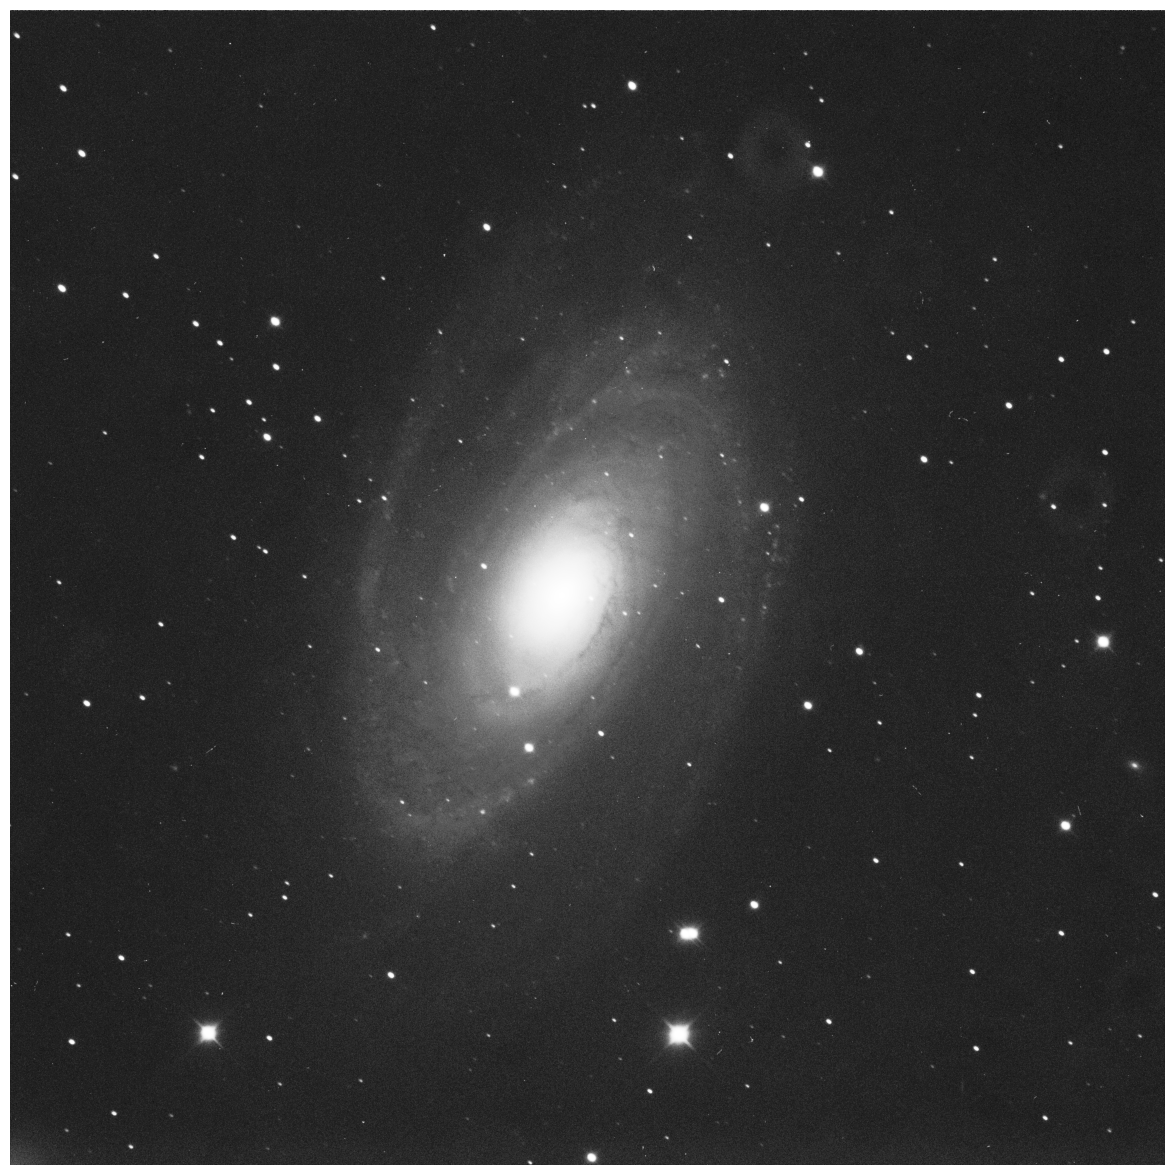

In [13]:
def scurveRNC01(img_data):
    '''
    scurve1 (contrast enhancement transformation) in RNC-color correction. Adapted from c source file.

    More details, please visit:
        http://www.clarkvision.com/articles/astrophotography-rnc-color-stretch/
        
    
    Parameters
    ----------
    img_data: 2D numpy.array, the input image data
    
    Returns
    -------
    tmp: 2D numpy.array, the output image data
    '''
    zp = 5.0 / (1.0 + np.exp(2.1)) - 0.58
    op = 5.0 / (1.0 + np.exp(-2.9)) - 0.58 - zp
    tmp = 5.0 / (1.0 + np.exp(-5.0 * (img_data - 0.42))) - 0.58
    tmp = (tmp - zp) / op
    return tmp


def midtone_transformation(img_data, low_clip=2.8, bg=0.25):
    '''
    Transformation used in many commercial image processing softwares
    
    Parameters
    ----------
    img_data: 2D numpy.array, the input image data
    low_clip: float, the shadow clipping point in sigma
    bg: float, the desired background value after transformation
    
    Returns
    -------
    img_stretched: 2D numpy.array, the stretched image data
    '''
    img_mean, _, img_std = sigma_clipped_stats(img_data, maxiters=10)
    # Clipping
    img_clipped = np.copy(img_data) - (img_mean - low_clip * img_std)
    img_clipped[img_clipped < 0.0] = 0.0
    # Solve for midtone
    img_mean = low_clip * img_std
    m = img_mean * (1.0 - bg) / (img_mean - 2.0 * bg * img_mean + bg)
    img_stretched = (m - 1.0) * img_clipped / ((2.0 * m - 1.0) * img_clipped - m)
    return img_stretched


img_m81 = CCDData.read("./calibrated/m81_300s.fit").data / 65535.0  # The stretch function would only work when pixel values are between 0 and 1
img_stretched = midtone_transformation(img_m81, bg=0.2)
# Contrast enhancement
for i in range(2):
    img_stretched = scurveRNC01(img_stretched)
plt.figure(figsize=(15, 15))
plt.imshow(img_stretched, cmap='Greys_r')
plt.axis('off')
plt.show()
# plt.savefig("M81_stretched.png")

In [14]:
# image, hdr= fits.getdata("./calibrated/Test_M81.fit",header=True)
# fits.writeto("M81_300s_stretched.fits",img_stretched,header=hdr)